# Implementation and training of LeNet for denoising

In [1]:
import torch
import torchvision
import numpy as np

from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import transforms

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

## Loading dataset from MNIST 32

In [3]:
# transform = transforms.Normalize((0.14,), (0.25,))      # Set mean to 0 and  var to 1

images, labels = torch.load('./.data/MNIST32_train.pkl')
# images = transform(images) 

all_train = torch.utils.data.TensorDataset(images, labels) 
train_size = int(0.9 * len(all_train))
val_size = len(all_train) - train_size

train_set, val_set = torch.utils.data.random_split(all_train, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers = 2, pin_memory = True)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False, num_workers = 2, pin_memory = True)

images, labels = torch.load('./.data/MNIST32_val.pkl')
# images = transform(images) 

test_data = torch.utils.data.TensorDataset(images, labels)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False, num_workers = 2, pin_memory = True)

## Creating the model

In [4]:
model = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size = 5, stride = 1, padding = 0),  # Extracts feautres     -> 28x28x6
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0),     # Reduce dimensionality -> 14x14x6

    nn.Conv2d(6, 16, kernel_size = 5, stride = 1, padding = 0), # Extracts feautres     -> 10x10x16
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0),     # Reduce dimensionality -> 5x5x16

    nn.Flatten(),       # 5x5x16 -> 400

    nn.Linear(400, 120),# Fully connected layer
    nn.ReLU(),
    nn.Linear(120, 84), # Fully connected layer
    nn.ReLU(),
    nn.Linear(84, 10),   # Non normalized output
)

model = model.to(device, non_blocking = True) 

## Training the classifier

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),
                       lr=1e-4,
                       weight_decay=1e-6)

In [6]:
def accuracy(y_pred, y):                      # we already provide an accuracy function

  pred = y_pred.detach().argmax(dim=1)
  corrects = (pred == y)

  accuracy = (corrects.sum()/corrects.size(0)).float()

  return accuracy

In [7]:
# this code is taken from https://github.com/Bjarten/early-stopping-pytorch
# Copyright (c) 2018 Bjarte Mehus Sunde under MIT License
# to see full license consult the NOTICE.txt file on the Github repository from which this notebook is taken from

class EarlyStopping:
  def __init__(self, patience=5, delta=0, verbose=False, path='checkpoint.pt'):
    self.patience = patience       # Number of epochs to wait for improvement
    self.delta = delta             # Minimum change in monitored metric to qualify as improvement
    self.verbose = verbose         # If True, print a message when validation metric improves
    self.path = path               # Path to save the model checkpoint
    self.counter = 0               # Counter to track epochs without improvement
    self.best_score = None         # Best validation metric achieved so far
    self.early_stop = False        # Flag to indicate whether to stop training

  def __call__(self, val_metric, model):
    if self.best_score is None:
      self.best_score = val_metric
      self.save_checkpoint(model)
    elif val_metric > self.best_score + self.delta:
      self.counter += 1
      if self.verbose:
        print(f'Epochs without improvement: {self.counter}')
      if self.counter >= self.patience:
                self.early_stop = True
    else:
      self.best_score = val_metric
      self.save_checkpoint(model)
      self.counter = 0


  def save_checkpoint(self, model):
    torch.save(model.state_dict(), self.path)

In [8]:
EPOCHS = 200
train_loss = []
val_loss = []
train_acc = []
val_acc = []

early_stopper = EarlyStopping(path=".checkpoint/model_checkpoint.pt")

for epoch in range(EPOCHS):
    model.train()
    tloss = 0
    tacc = 0
    for batch_idx, (x, y) in enumerate(train_loader):
        x = x.to(device, non_blocking = True)
        y = y.to(device, non_blocking = True)
        pred = model(x)

        loss = criterion(pred, y)

        for param in model.parameters():
            param.grad = None
        loss.backward()
        optimizer.step()

        tloss += loss.detach()
        tacc += accuracy(pred, y)

    train_loss.append(tloss/len(train_loader))
    train_acc.append(tacc/len(train_loader))

    model.eval()
    tloss = 0
    tacc = 0
    for batch_idx, (x, y) in enumerate(val_loader):
        x = x.to(device, non_blocking = True)
        y = y.to(device, non_blocking = True)
        pred = model(x)

        loss = criterion(pred, y)

        tloss += loss.detach()
        tacc += accuracy(pred, y)
    
    val_loss.append(tloss/len(val_loader))
    val_acc.append(tacc/len(val_loader))

    early_stopper(val_loss[-1], model)
    print(f"Epoch {epoch + 1}: \nTrain Loss = {train_loss[-1]:.5f}, Validation Loss = {val_loss[-1]:.5f}")
    print(f"Train Acc = {train_acc[-1]:-5f}, Validation Acc = {val_acc[-1]:-5f}")
    if early_stopper.early_stop:
      print("Early stopping triggered.")
      break


Epoch 1: 
Train Loss = 1.27158, Validation Loss = 0.43391
Train Acc = 0.640583, Validation Acc = 0.876187
Epoch 2: 
Train Loss = 0.31873, Validation Loss = 0.26266
Train Acc = 0.903505, Validation Acc = 0.917886
Epoch 3: 
Train Loss = 0.22796, Validation Loss = 0.20973
Train Acc = 0.930489, Validation Acc = 0.931231
Epoch 4: 
Train Loss = 0.19012, Validation Loss = 0.18504
Train Acc = 0.940475, Validation Acc = 0.940088
Epoch 5: 
Train Loss = 0.16631, Validation Loss = 0.16006
Train Acc = 0.947960, Validation Acc = 0.948898
Epoch 6: 
Train Loss = 0.14720, Validation Loss = 0.14701
Train Acc = 0.953762, Validation Acc = 0.952674
Epoch 7: 
Train Loss = 0.13217, Validation Loss = 0.13282
Train Acc = 0.957796, Validation Acc = 0.954431
Epoch 8: 
Train Loss = 0.12019, Validation Loss = 0.11847
Train Acc = 0.961144, Validation Acc = 0.960795
Epoch 9: 
Train Loss = 0.10997, Validation Loss = 0.10670
Train Acc = 0.964397, Validation Acc = 0.964642
Epoch 10: 
Train Loss = 0.10135, Validation Lo

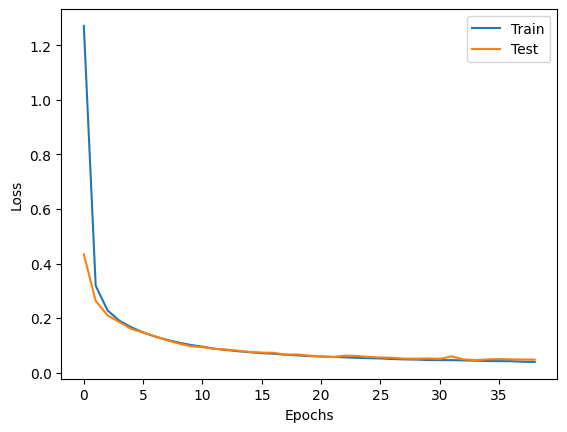

In [9]:
import matplotlib.pyplot as plt
train_loss = [it.cpu() for it in train_loss]
tloss = [it.cpu() for it in val_loss]
plt.plot(train_loss, label = "Train")
plt.plot(tloss, label = "Test")

plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.legend()

plt.show()

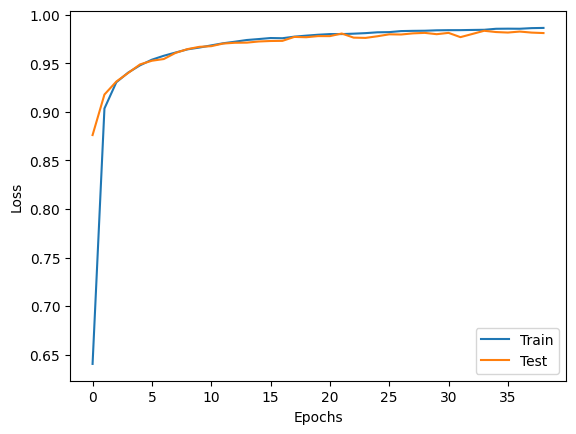

In [10]:
train_acc = [it.cpu() for it in train_acc]
tacc= [it.cpu() for it in val_acc]
plt.plot(train_acc, label = "Train")
plt.plot(tacc, label = "Test")

plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.legend()

plt.show()

In [11]:
model.eval()
tloss = 0
tacc = 0
for batch_idx, (x, y) in enumerate(test_loader):
    x = x.to(device, non_blocking = True)
    y = y.to(device, non_blocking = True)
    pred = model(x)

    loss = criterion(pred, y)

    tloss += loss.detach()
    tacc += accuracy(pred, y)

tloss = (tloss/len(test_loader))
tacc = (tacc/len(test_loader))
print(f"Test Loss = {tloss:-5f}, Test Acc = {tacc:-5f}")

Test Loss = 0.044261, Test Acc = 0.985166
